# CAB420 Assignment 1A Question 3

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import scipy.io
import numpy
# numpy.set_printoptions(threshold=numpy.inf)

import os
import datetime
import pydot
import IPython
from IPython.display import SVG

# Question 1
Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs, class_weights):
    
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        class_weight=class_weights)    
    
    model.load_weights(filename)
    model.save(filename)    
    
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Testing')

In [4]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

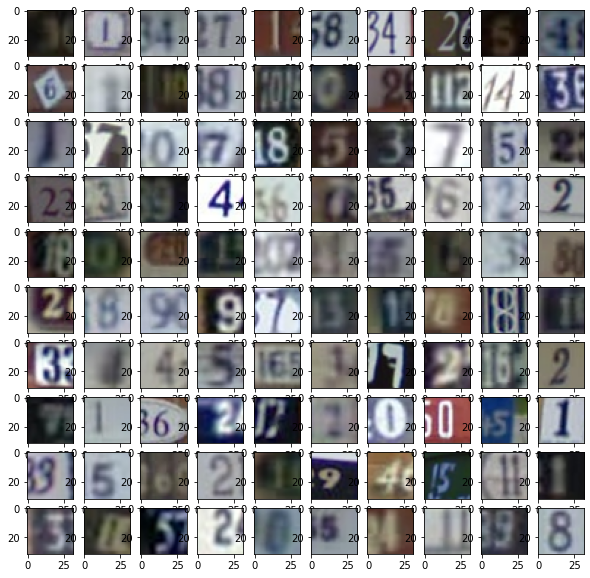

In [5]:
SVHN_train = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_train.mat')
SVHN_test = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_test.mat')
# print(SVHN_test)
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(SVHN_train['train_X'][:,:,:,i])

In [6]:
# Change class from [1 - 10] to [0 - 9] as keras takes 0 - 9

for i in range (len(SVHN_train['train_Y'])):
    SVHN_train['train_Y'][i] = SVHN_train['train_Y'][i] - 1
for i in range (len(SVHN_test['test_Y'])):
    SVHN_test['test_Y'][i] = SVHN_test['test_Y'][i] - 1


In [7]:
# Do we need to preserve rbg value(3) in a 4D, or just put 1 in the end
train = numpy.transpose(SVHN_train['train_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
train_y = SVHN_train['train_Y']
test = numpy.transpose(SVHN_test['test_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
test_y = SVHN_test['test_Y']

class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())

# fig = plt.figure(figsize=[10, 10])
# for i in range(100):
#     ax = fig.add_subplot(10, 10, i + 1)
#     ax.imshow(train[i,:,:,:])

Train on 1000 samples, validate on 10000 samples
Epoch 1/30
1000/1000 [==============================] - 7s 7ms/sample - loss: 2.3133 - accuracy: 0.1130 - val_loss: 2.2849 - val_accuracy: 0.1633
Epoch 2/30
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.2739 - accuracy: 0.1610 - val_loss: 2.2655 - val_accuracy: 0.1894
Epoch 3/30
1000/1000 [==============================] - 6s 6ms/sample - loss: 2.2649 - accuracy: 0.1800 - val_loss: 2.2657 - val_accuracy: 0.1881
Epoch 4/30
1000/1000 [==============================] - 6s 6ms/sample - loss: 2.2674 - accuracy: 0.1820 - val_loss: 2.2606 - val_accuracy: 0.1923
Epoch 5/30
1000/1000 [==============================] - 6s 6ms/sample - loss: 2.2573 - accuracy: 0.1850 - val_loss: 2.2610 - val_accuracy: 0.1901
Epoch 6/30
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.2446 - accuracy: 0.2070 - val_loss: 2.2620 - val_accuracy: 0.1937
Epoch 7/30
1000/1000 [==============================] - 5s 5ms/sample - los

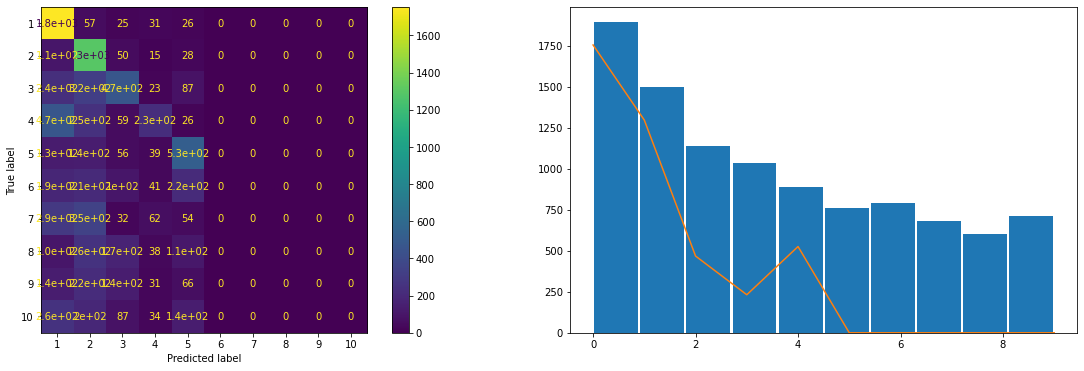

In [8]:
def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn
model_last = build_model(10)
model_last.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_last.fit(train, train_y,
                        batch_size=128,
                        epochs=30,
                        validation_data=(test, test_y))
eval_model(model_last, test, test_y)

Text(0.5, 1.0, 'Training Performance')

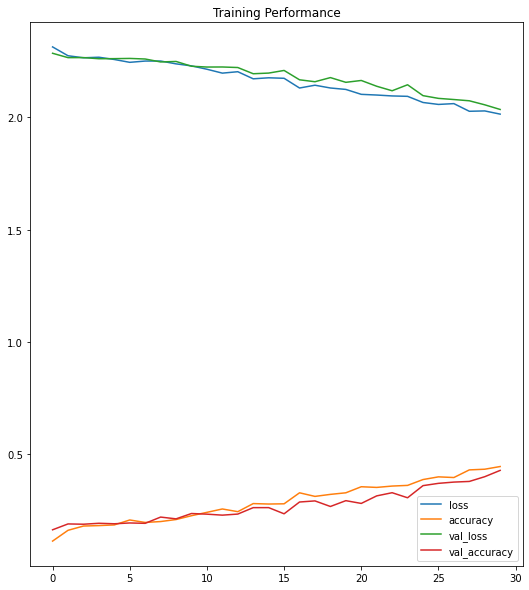

In [9]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()
ax.set_title('Training Performance')

### vgg_2stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.7627 - accuracy: 0.1328
Epoch 00001: val_loss improved from inf to 72.91701, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 14s 14ms/sample - loss: 2.7161 - accuracy: 0.1400 - val_loss: 72.9170 - val_accuracy: 0.0789
Epoch 2/20
 896/1000 [=========================>....] - ETA: 0s - loss: 2.2084 - accuracy: 0.2388
Epoch 00002: val_loss improved from 72.91701 to 10.33025, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 11s 11ms/sample - loss: 2.2162 - accuracy: 0.2340 - val_loss: 10.3302 - val_accuracy: 0.1163
Epoch 3/20
 896/1000 [=========================>....] - ETA: 0s - loss: 1.9983 - accuracy: 0.3203
Epoch 00003: val_loss did not improve from 10.33025
1000/1000 [==============================] - 11s 11ms/sample - loss: 2.0040 - accuracy: 0.3200 - val_loss: 15.3191 - val_accuracy: 0.1510
Ep

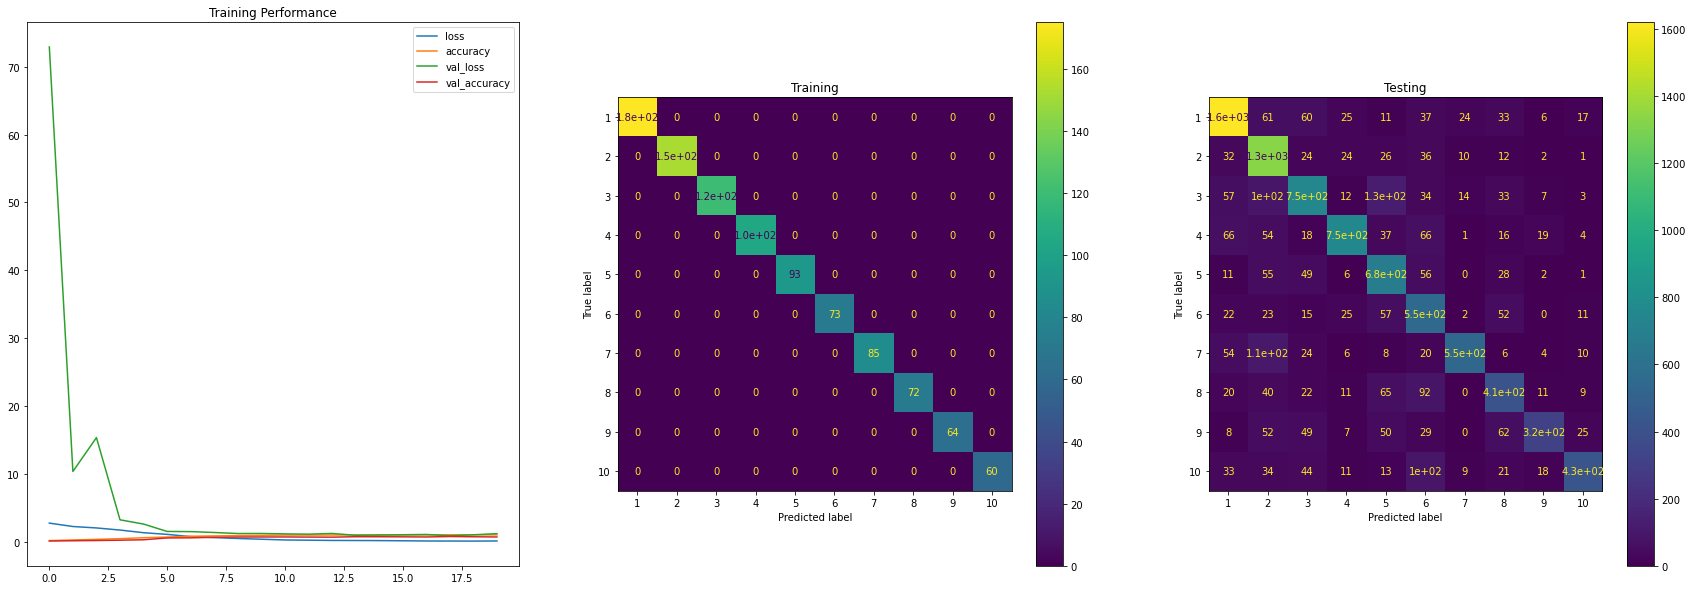

In [10]:
batch_size = 128
num_epochs = 20
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, train, train_y, test, test_y, 'vgg_2stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 8s - loss: 0.8559 - accuracy: 0.7396
Test loss: 0.8558874185562134
Test accuracy: 0.7396


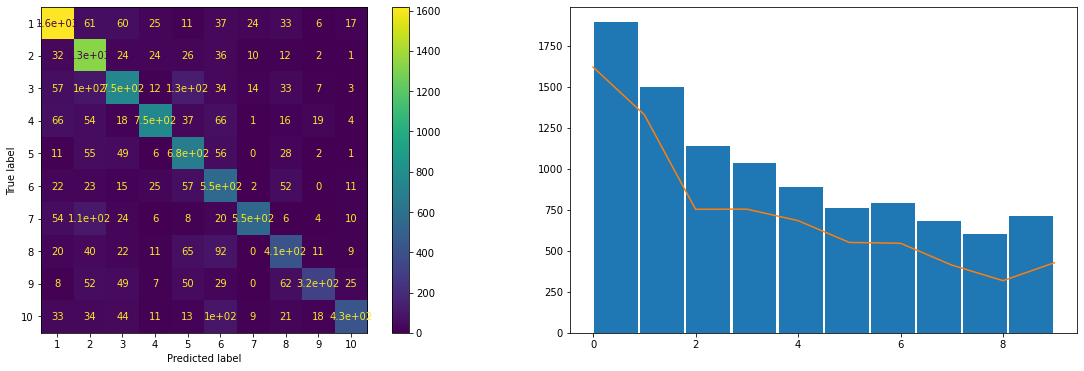

In [11]:
eval_model(model_cnn, test, test_y)

### vgg_3stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.7388 - accuracy: 0.1049
Epoch 00001: val_loss improved from inf to 2.66816, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 13s 13ms/sample - loss: 2.7234 - accuracy: 0.1080 - val_loss: 2.6682 - val_accuracy: 0.0607
Epoch 2/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.3981 - accuracy: 0.1998
Epoch 00002: val_loss improved from 2.66816 to 2.33671, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 12s 12ms/sample - loss: 2.3726 - accuracy: 0.2040 - val_loss: 2.3367 - val_accuracy: 0.1615
Epoch 3/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.1958 - accuracy: 0.2411
Epoch 00003: val_loss did not improve from 2.33671
1000/1000 [==============================] - 11s 11ms/sample - loss: 2.1833 - accuracy: 0.2520 - val_loss: 2.5552 - val_accuracy: 0.1050
Epoch 4/3

Epoch 27/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9855
Epoch 00027: val_loss did not improve from 0.78313
1000/1000 [==============================] - 12s 12ms/sample - loss: 0.0712 - accuracy: 0.9850 - val_loss: 0.7955 - val_accuracy: 0.7643
Epoch 28/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9866
Epoch 00028: val_loss improved from 0.78313 to 0.76808, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.0702 - accuracy: 0.9880 - val_loss: 0.7681 - val_accuracy: 0.7748
Epoch 29/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0509 - accuracy: 0.9955
Epoch 00029: val_loss improved from 0.76808 to 0.76723, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 11s 11ms/sample - loss: 0.0543 - accuracy: 0.9940 - val_loss: 0.7672 - val_accuracy: 0.7747
Epoch 30/35
 896/1000 [=========================>..

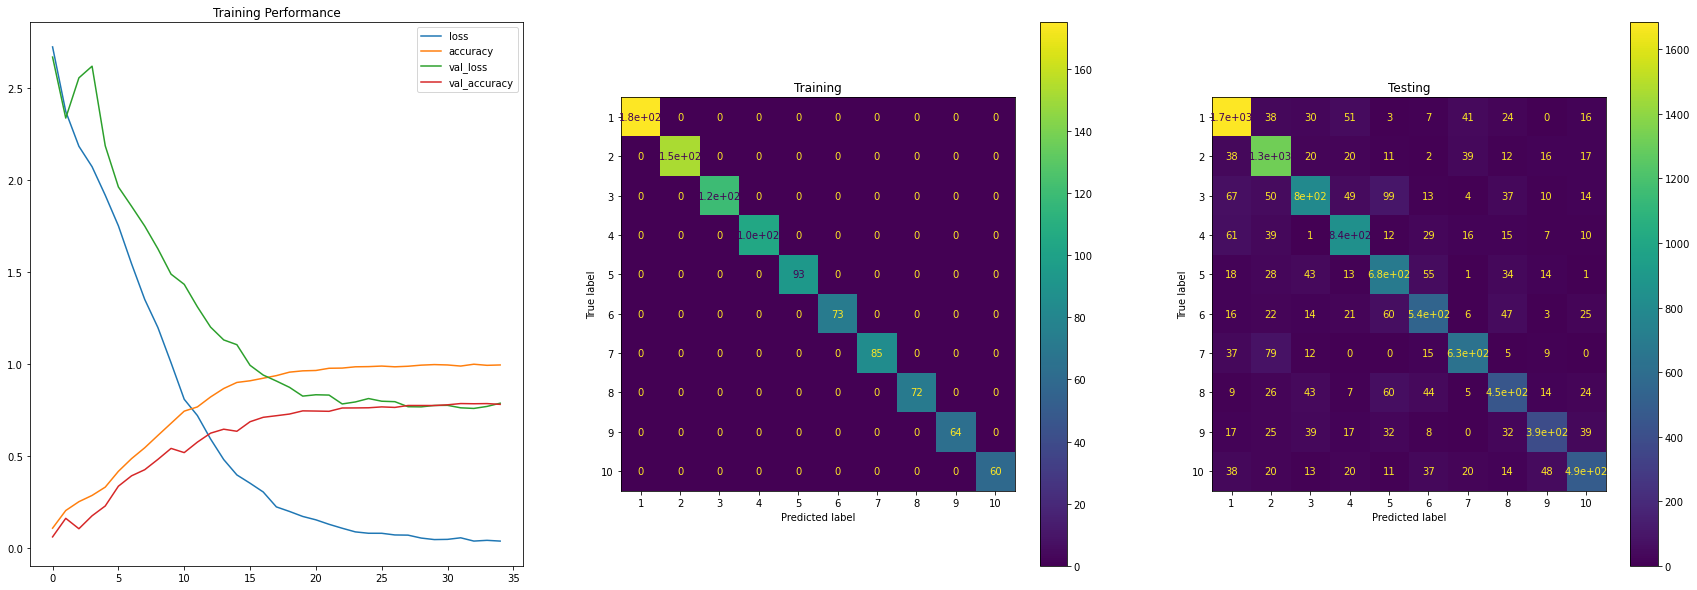

In [12]:
num_epochs = 35
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32,64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_3stage_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_3stage_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
train_and_eval(model_3stage_cnn, train, train_y, test, test_y, 'vgg_3stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 8s - loss: 0.7588 - accuracy: 0.7842
Test loss: 0.758795772600174
Test accuracy: 0.7842


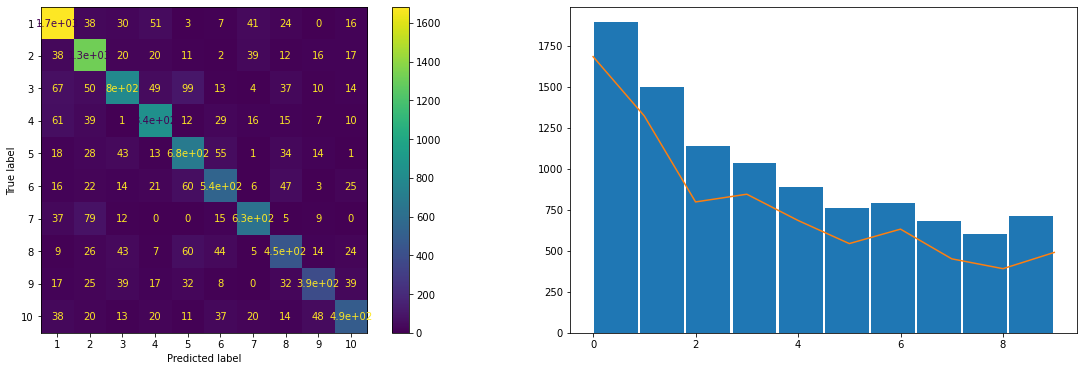

In [13]:
eval_model(model_3stage_cnn, test, test_y)

# Question 2
Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.

In [14]:
datagen = ImageDataGenerator(
                            # rotate between -10, +10 degrees
                            rotation_range=10,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for randomly applying a shearing transform
                            shear_range=0.05,
                            # range for zooming
                            zoom_range=0.05,
                            # don't allow horizontal flips of data
                            horizontal_flip=False,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

In [15]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_augmented_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_augmented_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model_augmented_cnn.fit_generator(datagen.flow(train, train_y, batch_size=128),
                    steps_per_epoch=1000//128,
                    epochs=100,
                    validation_data=(test, test_y), verbose=False,
                                           class_weight=class_weights)
                    

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']


10000/10000 - 8s - loss: 0.6497 - accuracy: 0.8331
Test loss: 0.6496814399123192
Test accuracy: 0.8331


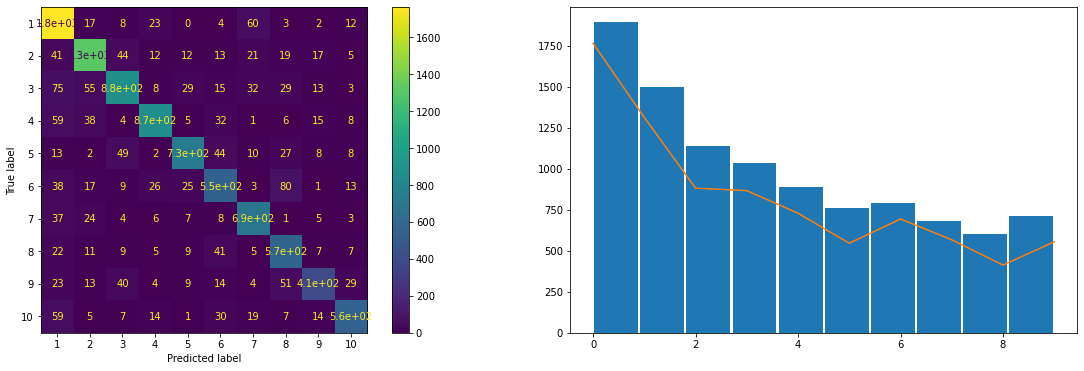

In [16]:
eval_model(model_augmented_cnn, test, test_y)

Text(0.5, 1.0, 'Training Performance')

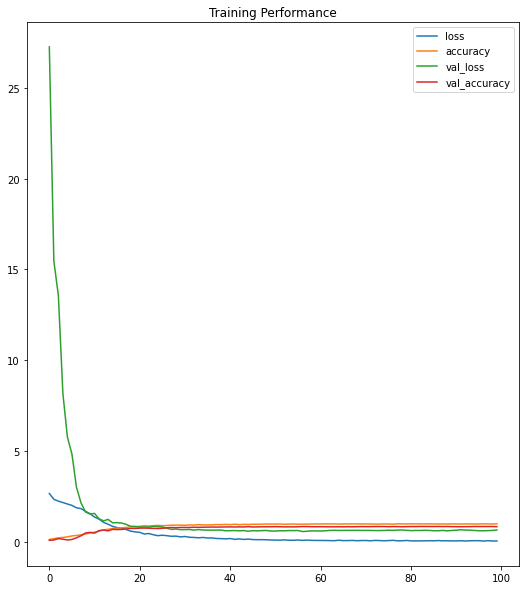

In [17]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()
ax.set_title('Training Performance')

In [18]:
model_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0

In [19]:
model_3stage_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0

In [20]:
model_augmented_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0